In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
from tensorflow.keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import resnet50
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import keras
import warnings
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os

from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

warnings.filterwarnings('ignore')

In [3]:
def data_prep(MildDementia, ModerateDementia, VerymildDementia, NonDemented):

    MildDementia= ["imagesoasis/Data/Mild Dementia" + '/' +  MildDementia for MildDementia in MildDementia]
    ModerateDementia= ["imagesoasis/Data/Moderate Dementia"  + '/' +  ModerateDementia for ModerateDementia in ModerateDementia]
    VerymildDementia= ["imagesoasis/Data/Very mild Dementia"  + '/' +  VerymildDementia for VerymildDementia in VerymildDementia]
    NonDemented= ["imagesoasis/Data/Non Demented"  + '/' +  NonDemented for NonDemented in NonDemented]

    labels = len(MildDementia)*['MildDementia'] + len(ModerateDementia)*['ModerateDementia'] + len(VerymildDementia)*['VerymildDementia'] + len(NonDemented)*['NonDemented']
    data = MildDementia + ModerateDementia + VerymildDementia + NonDemented

    return pd.DataFrame({'Image_Path': data , 'Labels': labels})

In [5]:
df = data_prep(os.listdir('imagesoasis/Data/Mild Dementia'), os.listdir('imagesoasis/Data/Moderate Dementia'),
               os.listdir('imagesoasis/Data/Very mild Dementia'), os.listdir('imagesoasis/Data/Non Demented'))

In [6]:
df = df.sample(frac=1).reset_index(drop=True)

In [9]:
df.sample(10)

,Image_Path,Labels
23210,imagesoasis/Data/Non Demented/OAS1_0095_MR1_mp...,NonDemented
79345,imagesoasis/Data/Non Demented/OAS1_0078_MR1_mp...,NonDemented
85971,imagesoasis/Data/Non Demented/OAS1_0280_MR1_mp...,NonDemented
49190,imagesoasis/Data/Non Demented/OAS1_0170_MR1_mp...,NonDemented
46449,imagesoasis/Data/Non Demented/OAS1_0091_MR1_mp...,NonDemented
15890,imagesoasis/Data/Non Demented/OAS1_0102_MR1_mp...,NonDemented
65192,imagesoasis/Data/Very mild Dementia/OAS1_0273_...,VerymildDementia
6637,imagesoasis/Data/Non Demented/OAS1_0136_MR1_mp...,NonDemented
23703,imagesoasis/Data/Non Demented/OAS1_0353_MR1_mp...,NonDemented
65647,imagesoasis/Data/Non Demented/OAS1_0017_MR1_mp...,NonDemented


In [11]:
def plot_images(class_label, df, num_images=5):

    class_df = df[df['Labels'] == class_label].head(num_images)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    axes = axes.flatten()

    for i, (img_path) in enumerate(class_df['Image_Path']):
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[i].imshow(img_rgb)
        axes[i].axis('off')
        axes[i].set_title(f'{class_label} - Image {i+1}')

    plt.tight_layout()
    plt.show()

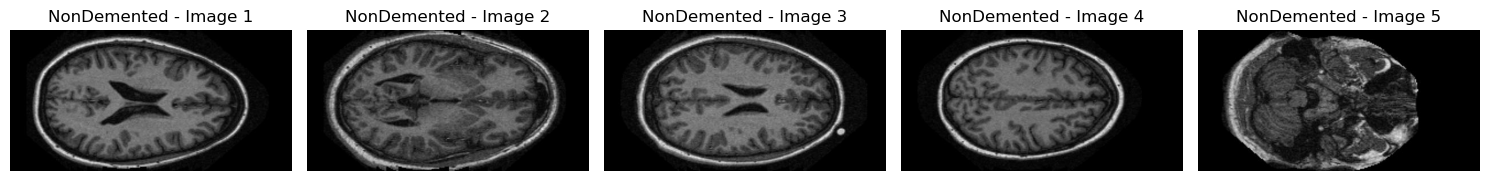

In [13]:
plot_images('NonDemented', df)

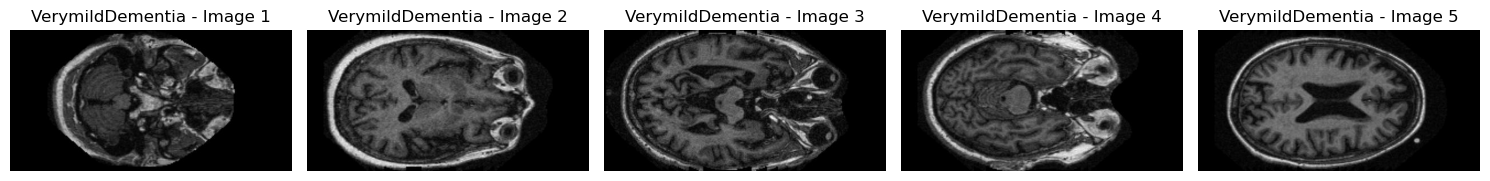

In [15]:
plot_images('VerymildDementia', df)

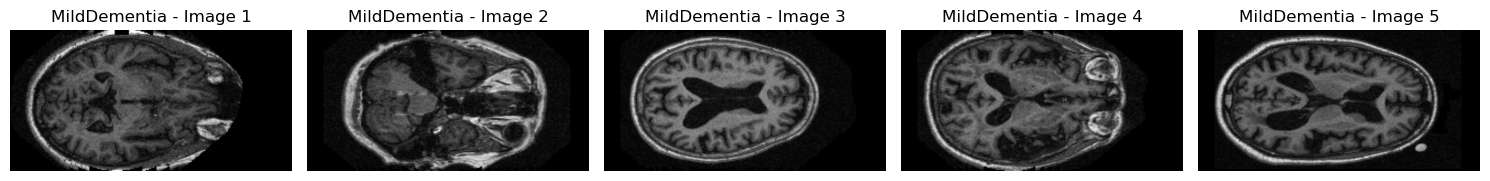

In [17]:
plot_images('MildDementia', df)

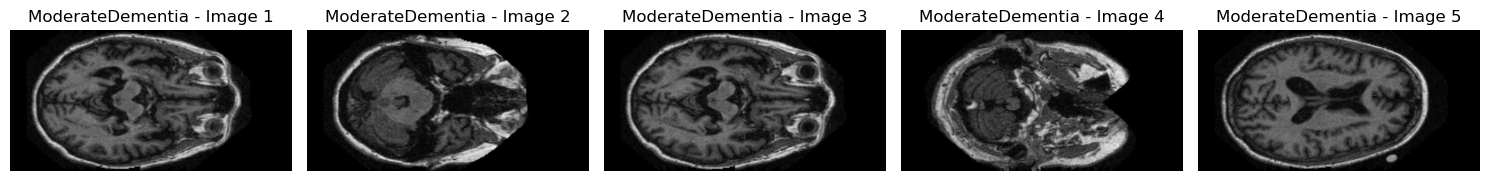

In [19]:
plot_images('ModerateDementia', df)

In [21]:
df.Labels.value_counts()

Labels
NonDemented         67222
VerymildDementia    13725
MildDementia         5002
ModerateDementia      488
Name: count, dtype: int64

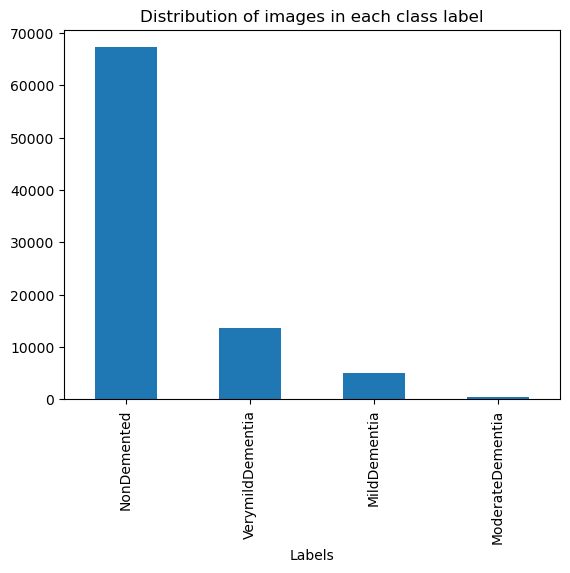

In [23]:
df['Labels'].value_counts().plot(kind = 'bar')
plt.title('Distribution of images in each class label')
plt.show()

Data is imbalanced hence reducing the data size by using the sample images from majority classes

In [26]:
df = df.groupby('Labels').apply(lambda x: x.sample(n=5000, random_state=42) if x['Labels'].iloc[0] in ['NonDemented', 'VerymildDementia', 'MildDementia'] else x)
df = df.reset_index(drop=True)

In [28]:
df.Labels.value_counts()

Labels
MildDementia        5000
NonDemented         5000
VerymildDementia    5000
ModerateDementia     488
Name: count, dtype: int64

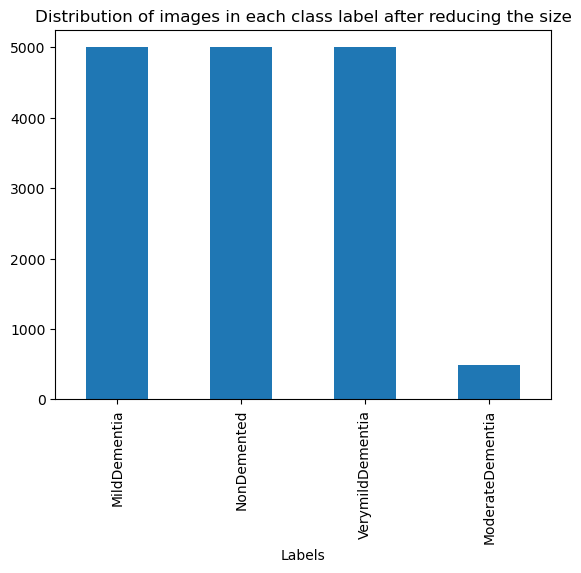

In [30]:
df['Labels'].value_counts().plot(kind = 'bar')
plt.title('Distribution of images in each class label after reducing the size')
plt.show()

In [32]:
train, test = train_test_split(df, test_size = .30)

In [34]:
datagen = ImageDataGenerator(
    rescale=1./255,                    # Rescale pixel values to [0, 1]
)

In [36]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory=None,                     # File paths are in the dataframe
    x_col='Image_Path',                 # Column with image file paths
    y_col='Labels',                     # Column with labels
    target_size=(224, 224),             # Resize images to 224x224 (or your desired size)
    batch_size=32,                      # Number of images to process in each batch
    class_mode='categorical',           # Classification task (one-hot encoding)
    shuffle=True                        # Shuffle the data
)

Found 10841 validated image filenames belonging to 4 classes.


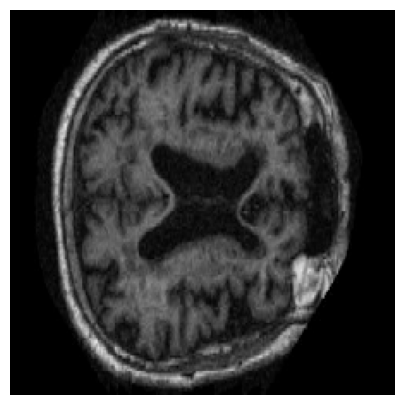

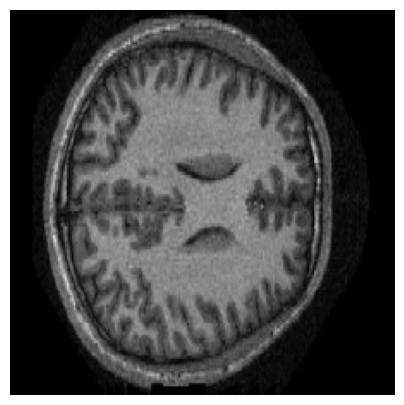

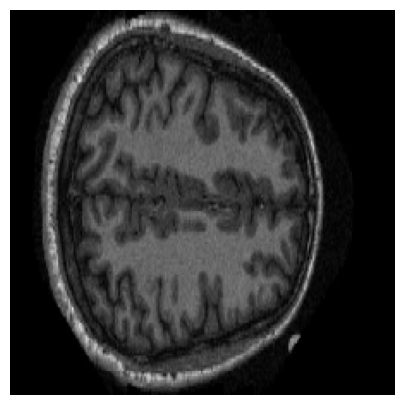

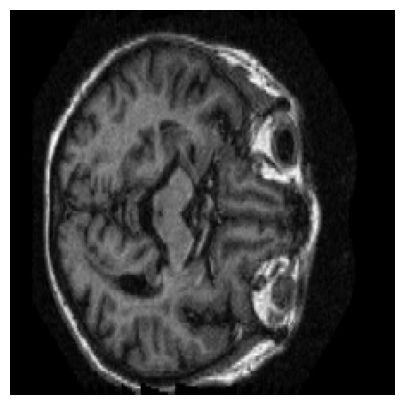

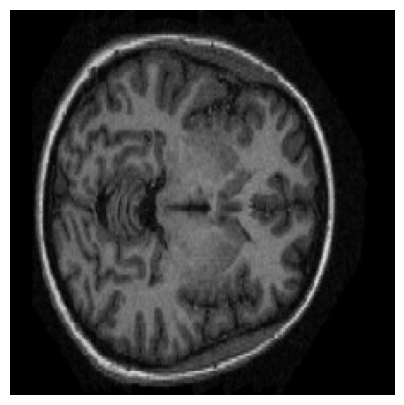

In [38]:
def augmented_images(generator, num_images=5):

    for i in range(num_images):
        img, label = next(generator)
        plt.figure(figsize=(5, 5))
        plt.imshow(img[0])
        plt.axis('off')
        plt.show()

augmented_images(train_generator, num_images=5)

In [40]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [42]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=None,                      # File paths are in the dataframe
    x_col='Image_Path',                   # Column with image file paths
    y_col='Labels',                       # Column with labels
    target_size=(224, 224),               # Resize images to 224x224 (or your desired size)
    batch_size=32,                        # Number of images to process in each batch
    class_mode='categorical',             # Classification task (one-hot encoding)
    shuffle=False                         # Do not shuffle test data
)

Found 4647 validated image filenames belonging to 4 classes.


In [44]:
model = Sequential()

# First convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
hist = model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 459s 1s/step - accuracy: 0.4708 - loss: 1.1246 - val_accuracy: 0.8575 - val_loss: 0.4042
Epoch 2/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 309s 913ms/step - accuracy: 0.8476 - loss: 0.3877 - val_accuracy: 0.9382 - val_loss: 0.1655
Epoch 3/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 316s 932ms/step - accuracy: 0.9216 - loss: 0.1937 - val_accuracy: 0.9623 - val_loss: 0.1029
Epoch 4/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - accuracy: 0.9472 - loss: 0.1391 - val_accuracy: 0.9718 - val_loss: 0.0770
Epoch 5/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - accuracy: 0.9623 - loss: 0.0940 - val_accuracy: 0.9748 - val_loss: 0.0705
Epoch 6/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 329s 971ms/step - accuracy: 0.9706 - loss: 0.0777 - val_accuracy: 0.9770 - val_loss: 0.0631
Epoch 7/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 310s 915ms/step - accuracy: 0.9717 - loss: 0.0727 - val_accuracy: 0.9839 - val_loss: 0.0538
Epoch 8/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 314s 925ms/step - accuracy: 0.9771 - loss: 0.

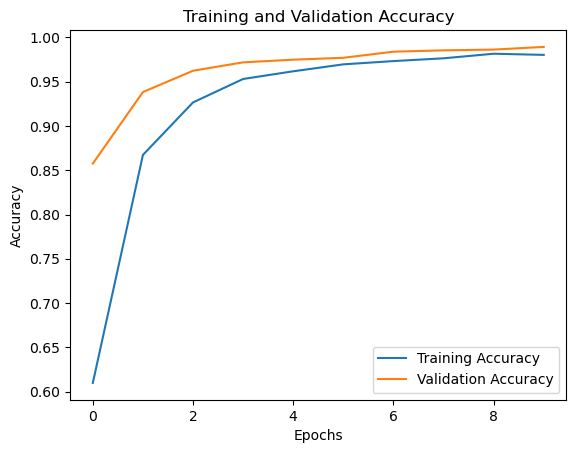

In [48]:
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

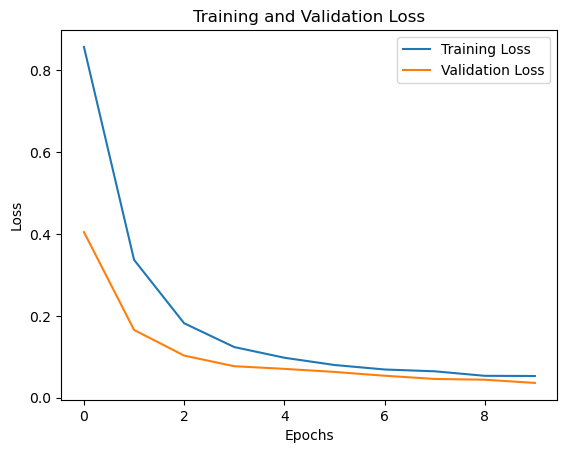

In [50]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()